Spatial scale: 10.1119 pixels/mm
Time scale: 60 fps

# Cutting the circle into slices

In [4]:
import cv2
import numpy as np
import pandas as pd 
import tifffile as tiff
import src.utils as utils

# Import old knee video
old_knee_video = tiff.imread("../data/1 aging_00000221.tif") # 312 frames, 1024 x 1280 resolution

# Import Excel data
data_set = "aging-1" # Change sheet using this parameter 
knee_angle_data = pd.read_excel("data\\Knee flexion degrees .xlsx", engine='openpyxl', sheet_name = data_set) 
# print(knee_angle_data.keys())

# Select columns and rename
flexion_degree = knee_angle_data.filter(['Frame Number', 'flexion degree']).rename(columns={'flexion degree': 'Degree'})
extension_degree = knee_angle_data.filter(['Frame Number.1', 'Extension degree']).rename(columns={'Frame Number.1': 'Frame Number', 'Extension degree': 'Degree'})

# Vertically concatenate data
knee_degree = pd.concat([flexion_degree, extension_degree], axis=0, ignore_index=True)

# Drop NaNs and cast frame numbers to int
knee_degree = knee_degree.dropna().astype({'Frame Number': np.uint16})

# Set first and last frame numbers 
first_frame = knee_degree['Frame Number'].iloc[0] # First frame 
last_frame = knee_degree['Frame Number'].iloc[-1] # Last frame
frame_num = first_frame # Initialize frame_num
total_frames = last_frame - first_frame

print(f"first frame = {first_frame}, last frame = {last_frame}")
print(f"total frames = {total_frames}")
frames_per_second = 60
print(f"frames_per_second = {frames_per_second}")
print(f"seconds/cycle = {total_frames/frames_per_second}")

# Iterate over all frames
loop_repeats = 0
while frame_num <= last_frame:   
   
    "Frame pre-processing"

    # Get current frame
    frame = old_knee_video[frame_num, :, :]
    frame = np.rot90(frame, k = -1)

    # Preprocessing
    frame, translation_mx = utils.centroid_stabilization(frame, blur_strength=2) 
    frame = utils.crop_square_frame(frame, n = 450) 
    frame_blurred = cv2.GaussianBlur(frame, (31,31), 0)

    # Save original frame
    frame_original = frame.copy()

    # Get dimensions
    h,w = frame.shape

    "Segmentation and boundary drawing"

    # Get adaptive mean mask (better)
    mean_mask = cv2.adaptiveThreshold(frame_blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,71, -2)
    
    # Clean up adaptive mean mask
    kernel_size = (15,15)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    mean_mask = cv2.morphologyEx(mean_mask, cv2.MORPH_OPEN, kernel)

    # Get contours of mean mask
    _, mean_contours, _ = cv2.findContours(mean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, mean_contours, -1, (0,0,255), 1) # Draw contours on frame

    # Show mean mask
    # cv2.imshow("mean mask", mean_mask)

    # TEMPORARY
    # frame = mean_mask

    "Estimating the femur"

    # Define vertical midpoint for the frame
    vertical_cutoff = 0.45
    vertical_midpoint = int(h*vertical_cutoff)

    # Split mean mask into top and bottom parts
    if frame_num in range(51, 67): # TODO: this could be cleaned up and generalized 
        bottom_slice = vertical_midpoint + 40 # Set custom width of the bottom mask
    else: 
        bottom_slice = h
    top_mask = mean_mask[:vertical_midpoint, :]
    bottom_mask = mean_mask[vertical_midpoint:bottom_slice, :]

    # Show the top and bottom masks
    # cv2.imshow("bottom_mask", bottom_mask)
    # cv2.imshow("top_mask", top_mask)

    # Find closest points to the left of the frame
    top_l_pt = utils.find_closest_point(top_mask, axis = 1)
    btm_l_pt = utils.find_closest_point(bottom_mask, axis = 1)
    btm_l_pt = (btm_l_pt[0],
                         btm_l_pt[1] + vertical_midpoint) # adjust the coordinate for plotting on the original frame

    # Get the midpoint between the left points
    left_midpoint = ( (int(round(top_l_pt[0] + btm_l_pt[0]) / 2)), 
                      (int(round(top_l_pt[1] + btm_l_pt[1]) / 2)) )
    
    # Draw the points
    cv2.circle(frame, top_l_pt, 3, (255,255,255), -1)
    cv2.circle(frame, btm_l_pt, 3, (255,255,255), -1)
    cv2.circle(frame, left_midpoint, 3, (255,255,255), -1)

    # Draw a point in the center of the frame
    ctr_pt = (round(w/2), int(h*0.495))
    cv2.circle(frame, ctr_pt, 3, (255,255,255), -1)

    # Draw the line representing the femur
    # cv2.line(frame, ctr_pt, left_midpoint, (255,255,255), 2)

    # Compute vector from ctr_pt to left_midpoint
    delta_x = left_midpoint[0] - ctr_pt[0]
    delta_y = left_midpoint[1] - ctr_pt[1]

    # Compute new endpoint by extending the vector
    femur_endpoint = (ctr_pt[0] + 2 * delta_x, ctr_pt[1] + 2 * delta_y)

    # Draw the extended line
    cv2.line(frame, ctr_pt, femur_endpoint, (255,255,255), 2)

    # Get the angle drawn between the line and the horizontal axis 
    delta = [ 
        ctr_pt[0] - left_midpoint[0], # (delta_x, delta_y)
        ctr_pt[1] - left_midpoint[1]
        ] 
    angle = np.arctan2(delta[1], delta[0])
    angle_deg = np.degrees(angle)

    # Rotate the frame by the angle
    # h,w = frame.shape
    # rotation_matrix = cv2.getRotationMatrix2D((round(w / 2), round(h / 2)), angle_deg, 1.0)
    # frame = cv2.warpAffine(frame, rotation_matrix, (w,h)) # Commit rotation

    "Drawing the circle"

    # Get the set of equally spaced points on the circle 
    N = 1
    points_on_circle = utils.get_N_points_on_circle(ctr_pt, femur_endpoint, N)

    # Plot the points
    # for pts in points_on_circle:
    #     cv2.circle(frame, pts, 1, (255,255,255), -1)

    # Draw lines to all the points
    for pts in points_on_circle:
        cv2.line(frame, ctr_pt, pts, (127,127,127), 1)

    # cv2.line(frame, ctr_pt, femur_endpoint, (255,255,255), 2) # Initial femur estimation



    "Displaying the frames"

    # Rescale frame
    pixel_scale = 10.1119 # pixels / mm
    frame, rescale_factor = utils.rescale_frame(frame, pixel_scale, scale_factor = 1.5)

    # Draw reference lines
    # draw_reference_lines(frame, horizontal_line_placement = 0.495)

    # Print current frame number on the bottom-left corner
    h,w = frame.shape
    bottom_left_position = (10, h - 10)
    cv2.putText(frame, str(frame_num), bottom_left_position, 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, 
                color = (255, 255, 255), thickness = 1, lineType=cv2.LINE_AA)
    
    # Print frame information on the top-left corner
    top_left_position = (10, 20)
    cv2.putText(frame, f"Obtaining N={N} radial slices", top_left_position, 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, 
                color = (255, 255, 255), thickness = 1, lineType=cv2.LINE_AA)
    
    # Draw 1 cm scale along the bottom of the frame
    utils.draw_scale_bar(frame, pixel_scale, rescale_factor) # Rescale the drawn bar 

    # Write scale length on frame
    cv2.putText(frame, f"({pixel_scale*10} px = 1 cm)", (21*w//32, h-15), 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.4, 
                color=(195,195,195), thickness=1, lineType=cv2.LINE_AA)

    # Display results
    cv2.imshow(f"Aging knee: Frames {first_frame} to {last_frame}", frame)    

    "Miscellaneous technical things "

    # Increment frame number 
    frame_num += 1

    # Optional: Loop video
    loop = True
    if loop and frame_num > last_frame:
        loop_repeats += 1
        frame_num = first_frame

    # Increment loop repeats
    max_loop_repeats = -1 # -1 to stop
    if loop_repeats == max_loop_repeats:
        break

    # Press 'q' to quit
    if cv2.waitKey(200) == ord('q'):
        break

cv2.destroyAllWindows()
print("program done!")

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\olimoon\\Documents\\Development\\Applied Math MSc 2024-2026\\knee segmentation\\notebooks\\data\\1 aging_00000221.tif'

# Notes from Apr 2 Meeting
- improve estimation of femur endpoint, i.e. centre of circle (to be discussed, maybe try to fit circle in the endpoint?)
    - optimization problem - try to fit circle of fixed size that overlaps with the boundary as closely as possible?
- improve estimation of femur location (fit least-squares line)

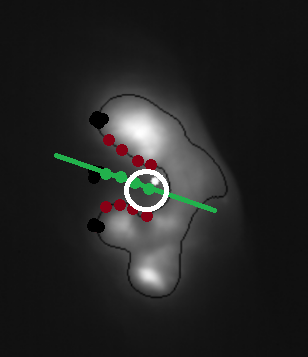
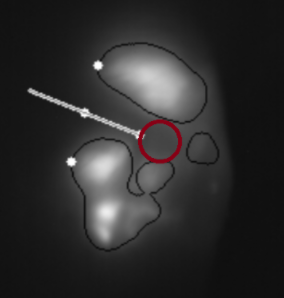

- get intensity plots for each of the slices / try to plot the flow from each slice to the next one?
- ~~Dr. Yu: measure the difference in intensity between each consecutive frame?~~
    - ~~approximation of the derivative, we can get the **change of pixel intensity per frame** to estimate the rate of flow? or at least rate of change within each segment~~

- ~~get new coordinates from Huizhu -> get new intensity plots~~
- ~~**send labeled pixel frames to Huizhu**~~

- ~~stabilize video for Kai (me? Darcy?)~~

# TODO: (Mar 4) (Update: Mar 10)
- ~~use Huizhu's new coordinates to estimate the fluid movement (aging knee) through the three parts using the change in intensity values (do this first)~~
- ~~get the total intensity in each part~~ 
- ~~plot total intensity in each part as a function of time (frame number)~~
- ~~ask Juan for his code to see how he did it~~

- ~~try the femur location estimation on the normal knee video (refine this later)
- ~~try to divide the knee into N segments in a 360 degree circle~~ (get intensity plots)
- try to estimate the tibia location using the knee angle data (hard)
- try to get the line representing the meniscus (very hard? maybe Darcy can try this)

- try to time-align the two videos (for visualization purposes)

- ~~ give Dr. Yu a side-by-side video of: (left side), original video centered and cropped; (middle side) centered original video with contour lines, femur line; (right side) binary mask ~~

# Notes for next meeting with Dr. Chen:
- we want to demonstrate we can make whatever tools we want, so we can ask for new data 
- address concerns about the experimental conditions being different between the normal and aging knees (not same resolution, different flexion/extension cycle durations)